In [ ]:
import numpy as np
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
# import wfdb
# import biosignalsnotebooks as bsnb
# from wfdb import processing
from matplotlib import pyplot as plt
# from scipy import signal
# from biosppy.signals import ecg
np.set_printoptions(threshold=sys.maxsize)
import umap
import sklearn.utils as slu
from sklearn.model_selection import LeaveOneOut
import seaborn as sns
from sklearn.metrics import *


from keras.utils.np_utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

In [ ]:
path = '/content/drive/MyDrive/ecg/'


In [ ]:
# path = '/content/drive/MyDrive/ecg/synthetic_data/lstm_sparse_vae'

def synthetic_data(file_name):
    path = '/content/drive/MyDrive/ecg/synthetic_data/' + file_name
    file_list = glob(path + '/*.csv')
    data = []
    # labels = np.full((960,1),label)
    labels = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,8.0]
    for i in range(len(file_list)):
    # for file_path in file_list:
        lbl = np.full((2944,1),labels[i])
        arr = np.genfromtxt(file_list[i], delimiter=',')
        arr = np.hstack((arr,lbl))
        data.append( arr )
    all_data = np.concatenate(data, axis=0)
    return all_data

In [ ]:
cnn_vae = synthetic_data('conv_vae')
cnn_sparse_vae = synthetic_data('sparse_conv_vae')
lstm_vae = synthetic_data('lstm_vae')
lstm_sparse_vae = synthetic_data('lstm_sparse_vae')

In [ ]:
mlii = np.loadtxt(path+'train_unsampled_mlii/mlii.csv', delimiter=',')
print(mlii.shape)

(108828, 259)


In [ ]:
mlii_shuffled = mlii
np.random.shuffle(mlii_shuffled)
from sklearn.model_selection import train_test_split
train, test = train_test_split(mlii_shuffled, test_size=0.25)

In [ ]:
anno = train[:,-3]
normal = train[anno == 1.0]
lbbb = train[anno == 2.0]
rbbb = train[anno == 3.0]
apb = train[anno == 4.0]
pvc = train[anno == 5.0]
fvn = train[anno == 6.0]
fpn = train[anno == 7.0]
paced = train[anno == 8.0]

abnormal = [lbbb,rbbb,apb,pvc,fvn,fpn,paced]
list_len = [len(i) for i in abnormal]
print(list_len)

all_classes = [normal,lbbb,rbbb,apb,pvc,fvn,fpn,paced]

num_of_vals = np.mean(list_len, dtype=int)
print(num_of_vals)

[6063, 5486, 1874, 5299, 616, 742, 5279]
3622


In [ ]:
def downsample(arr,n,seed):
    downsampled = slu.resample(arr,replace=False,n_samples=n,random_state=seed)
    return downsampled

In [ ]:
sampled_data = []
for i in all_classes:
  # print(i.shape[0])
  if i.shape[0] > num_of_vals//2:
      i = downsample(i, num_of_vals//2,42)
  sampled_data.append(i)

print(len(sampled_data))

8


In [ ]:
sampled_data_new = []
for i in sampled_data:
  i = np.delete(i, [-1,-2],axis=1)
  sampled_data_new.append(i)

print(sampled_data_new[0].shape)

(1811, 257)


In [ ]:
print(sampled_data_new[0].shape)

(1811, 257)


In [ ]:
synth_model = lstm_sparse_vae

In [ ]:
anno = synth_model[:,-1]
normal_synth = synth_model[anno == 1.0]
lbbb_synth = synth_model[anno == 2.0]
rbbb_synth = synth_model[anno == 3.0]
apb_synth = synth_model[anno == 4.0]
pvc_synth = synth_model[anno == 5.0]
fvn_synth = synth_model[anno == 6.0]
fpn_synth = synth_model[anno == 7.0]
paced_synth = synth_model[anno == 8.0]

all_classes_synth = [normal_synth,lbbb_synth,rbbb_synth,apb_synth,pvc_synth,fvn_synth,fpn_synth,paced_synth]

In [ ]:
synth_real_data = []
for i in range(len(sampled_data_new)):
  diff = num_of_vals - sampled_data_new[i].shape[0]
  # print(diff)
  # synth_samps = np.random.choice(all_classes_synth[i], diff, replace=False)
  synth_samps = all_classes_synth[i][:diff]
  sampled_data[i] = np.concatenate((sampled_data_new[i], synth_samps))
  # print(sampled_data[i].shape)
  synth_real_data.append(sampled_data[i])

print(len(synth_real_data))

8


In [ ]:
synth_real_arr = np.concatenate(synth_real_data, axis=0)
np.random.shuffle(synth_real_arr)
print(synth_real_arr.shape)

(28914, 257)


In [ ]:
X_train = synth_real_arr[:,:-1]
y_train = synth_real_arr[:,-1]

In [ ]:
# np.random.shuffle(cnn_vae)
# X_train_synth = lstm_sparse_vae[:,:-1]
# y_train_synth = lstm_sparse_vae[:,-1]

X_test = test[:,:-3]
y_test = test[:, -3]
print(X_train.shape)
print(y_train.shape)
print(test.shape)
print(X_test.shape)
print(y_test.shape)

(28914, 256)
(28914,)
(27207, 259)
(27207, 256)
(27207,)


In [ ]:
X_train_3d = X_train.reshape(-1, X_train.shape[1],1)
X_test_3d = X_test.reshape(-1, X_test.shape[1], 1)

print(X_train_3d.shape)
print(X_test_3d.shape)

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
print(y_train_cat.shape)
print(y_test_cat.shape)

(28914, 256, 1)
(27207, 256, 1)
(28914, 9)
(27207, 9)


In [ ]:
verbose, epoch, batch_size = 1, 10, 128

def getModel():
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train_3d.shape[1],X_train_3d.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(64, activation='relu'))
    cnnmodel.add(Dense(32, activation='relu'))
    cnnmodel.add(Dense(9, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = getModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 255, 128)          384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 127, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 126, 64)           16448     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 63, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 62, 32)            4128      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 31, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 30, 16)            1

In [ ]:
model = cnnmodel.fit(X_train_3d, y_train_cat, epochs=epoch, validation_split=0.2, verbose=verbose,batch_size=batch_size)

Epoch 1/10
181/181 [==============================] - 21s 110ms/step - loss: 1.1973 - accuracy: 0.5751 - val_loss: 0.2282 - val_accuracy: 0.9403
Epoch 2/10
181/181 [==============================] - 19s 107ms/step - loss: 0.2616 - accuracy: 0.9248 - val_loss: 0.1576 - val_accuracy: 0.9552
Epoch 3/10
181/181 [==============================] - 19s 107ms/step - loss: 0.1813 - accuracy: 0.9462 - val_loss: 0.1337 - val_accuracy: 0.9599
Epoch 4/10
181/181 [==============================] - 19s 107ms/step - loss: 0.1529 - accuracy: 0.9560 - val_loss: 0.0980 - val_accuracy: 0.9694
Epoch 5/10
181/181 [==============================] - 20s 108ms/step - loss: 0.1187 - accuracy: 0.9627 - val_loss: 0.0871 - val_accuracy: 0.9729
Epoch 6/10
181/181 [==============================] - 19s 107ms/step - loss: 0.1047 - accuracy: 0.9682 - val_loss: 0.0885 - val_accuracy: 0.9741
Epoch 7/10
181/181 [==============================] - 20s 113ms/step - loss: 0.0946 - accuracy: 0.9700 - val_loss: 0.0788 - val_ac

In [ ]:
cnnpredictions = cnnmodel.predict(X_test_3d, verbose=1)

851/851 [==============================] - 7s 8ms/step


In [ ]:
cnn_predict = np.argmax(cnnpredictions, axis=1)
true_value = np.argmax(y_test_cat,axis=1)

In [ ]:
def cf_matrix_func(predictions, y_test):
    cm = confusion_matrix(y_test, predictions)
    categories=['N', 'L', 'R', 'A', 'V', 'F', 'f','P']
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, 
                fmt='.2%', cmap='Blues',xticklabels=categories,yticklabels=categories)
    plt.xlabel('predicted label')
    plt.ylabel('true label')

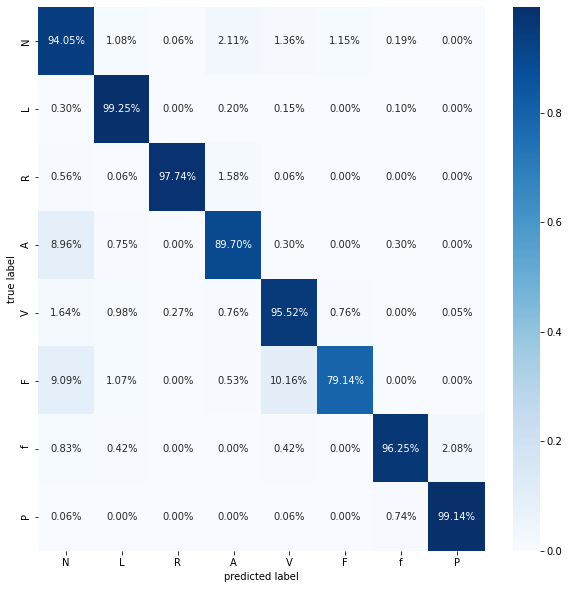

In [ ]:
cf_matrix_func(cnn_predict,true_value)

In [ ]:
c_r = classification_report(true_value, cnn_predict, labels=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,8.0], output_dict=True)

In [ ]:
import pandas as pd
df = pd.DataFrame(c_r).transpose()
df.to_csv(path + 'report_cnn_vae_mixed.csv')